In [2]:
import pandas as pd
import sklearn
import seaborn as sns
import sqlite3 as sql
import matplotlib.pyplot as plt

In [3]:
conn = sql.connect("data/agri.db")
query = "SELECT * from farm_data"
df = pd.read_sql_query(query, conn)

conn.close()

## Overview of Data

Let's look at our data to get an initial overview and see what we are working with

In [4]:
df.head()


,System Location Code,Previous Cycle Plant Type,Plant Type,Plant Stage,Temperature Sensor (°C),Humidity Sensor (%),Light Intensity Sensor (lux),CO2 Sensor (ppm),EC Sensor (dS/m),O2 Sensor (ppm),Nutrient N Sensor (ppm),Nutrient P Sensor (ppm),Nutrient K Sensor (ppm),pH Sensor,Water Level Sensor (mm)
0,Zone_D,Herbs,Vine Crops,Maturity,23.34,NaN,454.0,937,1.82,4,161,64,201,6.1,28.150346
1,Zone_G,Herbs,VINE CROPS,Vegetative,-24.16,63.14,441.0,938,2.13,6,161,53,None,6.5,31.000000
2,Zone_F,Herbs,herbs,maturity,23.84,NaN,562.0,1246,1.21,8,228,79,292,6.4,26.000000
3,Zone_G,Herbs,fruiting vegetables,Vegetative,22.61,NaN,651.0,1346,1.96,6,None,53 ppm,289,6.6,NaN
4,Zone_B,Vine Crops,LEAFY GREENS,seedling,22.88,NaN,144.0,812,2.76,5,61,19,168,5.5,28.000000


In [5]:
print(f"Shape: {df.shape}")

Shape: (57489, 15)


In [6]:
df.describe()

,Temperature Sensor (°C),Humidity Sensor (%),Light Intensity Sensor (lux),CO2 Sensor (ppm),EC Sensor (dS/m),O2 Sensor (ppm),pH Sensor,Water Level Sensor (mm)
count,48800.000000,18622.000000,53211.000000,57489.000000,57489.000000,57489.000000,57489.000000,48847.000000
mean,22.138201,69.243535,397.841668,1083.376576,1.624435,6.580842,6.021446,25.716878
std,7.556981,5.725973,222.923860,172.570351,0.415535,1.145534,0.400251,5.815294
min,-28.570000,59.220000,-799.000000,799.000000,-0.250000,3.000000,3.800000,10.001955
25%,22.140000,64.340000,257.000000,950.000000,1.360000,6.000000,5.800000,21.313361
50%,23.210000,68.700000,403.000000,1071.000000,1.650000,7.000000,6.000000,26.000000
75%,24.350000,74.117500,553.000000,1178.000000,1.900000,7.000000,6.300000,30.000000
max,28.750000,81.140000,800.000000,1500.000000,3.440000,11.000000,7.800000,39.998717


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57489 entries, 0 to 57488
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   System Location Code          57489 non-null  object 
 1   Previous Cycle Plant Type     57489 non-null  object 
 2   Plant Type                    57489 non-null  object 
 3   Plant Stage                   57489 non-null  object 
 4   Temperature Sensor (°C)       48800 non-null  float64
 5   Humidity Sensor (%)           18622 non-null  float64
 6   Light Intensity Sensor (lux)  53211 non-null  float64
 7   CO2 Sensor (ppm)              57489 non-null  int64  
 8   EC Sensor (dS/m)              57489 non-null  float64
 9   O2 Sensor (ppm)               57489 non-null  int64  
 10  Nutrient N Sensor (ppm)       47515 non-null  object 
 11  Nutrient P Sensor (ppm)       51791 non-null  object 
 12  Nutrient K Sensor (ppm)       53788 non-null  object 
 13  p

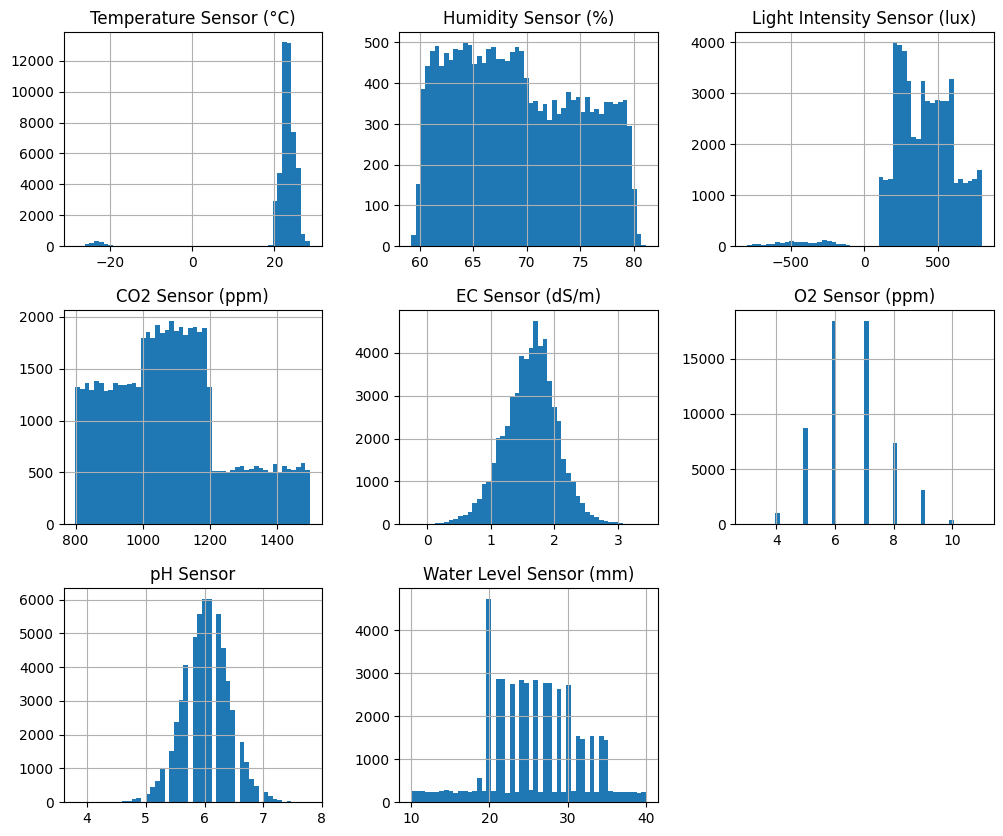

In [8]:
df.hist(bins=50, figsize=(12,10))
plt.show()

Based on our preliminary overview, we note down the following:

* Null values exist throughout many features
* Humidity is mostly null
* Nutrient N, P and K Sensor features are of the wrong data type
* Negative values exist in temperature, light intensity and EC. Light intensity and Electrical conductivity cannot be negative
* Although crops can grow in cold temperatures, looking at the histogram, the absense of readings inbetween the positive and negative readings shows that this is more likely due to sensor error

Before, we create our test split, let us do some quick cleaning of our data to fix the obvious issues. We start with the mismatch of data types of Nutrients N, P and K sensor.

In [9]:
columns = ['Nutrient N Sensor (ppm)', 'Nutrient P Sensor (ppm)', 'Nutrient K Sensor (ppm)']

for column in columns:
  # Replace None with NaN
  df[column] = df[column].replace('None', None)
  
  # Remove ppm suffix
  df[column] = df[column].str.replace('ppm', '', regex=True)
  
  # Convert to float64
  df[column] = df[column].astype('float64')

We now look at the negative values

In [10]:
numerical_df = df.select_dtypes(include=['float64', 'int64'])
print("Negative values count:")
print((numerical_df < 0).sum())

Negative values count:
Temperature Sensor (°C)         1252
Humidity Sensor (%)                0
Light Intensity Sensor (lux)    1385
CO2 Sensor (ppm)                   0
EC Sensor (dS/m)                  14
O2 Sensor (ppm)                    0
Nutrient N Sensor (ppm)            0
Nutrient P Sensor (ppm)            0
Nutrient K Sensor (ppm)            0
pH Sensor                          0
Water Level Sensor (mm)            0
dtype: int64


In [11]:
numerical_df_null = numerical_df[numerical_df.isnull()]
print("Null values count")
print((numerical_df_null<0).sum())

Null values count
Temperature Sensor (°C)         0
Humidity Sensor (%)             0
Light Intensity Sensor (lux)    0
CO2 Sensor (ppm)                0
EC Sensor (dS/m)                0
O2 Sensor (ppm)                 0
Nutrient N Sensor (ppm)         0
Nutrient P Sensor (ppm)         0
Nutrient K Sensor (ppm)         0
pH Sensor                       0
Water Level Sensor (mm)         0
dtype: int64


Since there is no overlap between null and negative values, we can proceed with removing the negative values. Let's confirm the amount of values that are negative

In [12]:
print(f"Percentage of negative values in Light Intensity Sensor: {(df['Light Intensity Sensor (lux)'] < 0).sum() / df['Light Intensity Sensor (lux)'].count() * 100 :.2f}")
print(f"Percentage of negative values in EC Sensor: {(df['EC Sensor (dS/m)'] < 0).sum() / df['EC Sensor (dS/m)'].count() * 100 :.2f}")
print(f"Percentage of negative values in Temperature Sensor: {(df['Temperature Sensor (°C)'] < 0).sum() / df['Temperature Sensor (°C)'].count() * 100 :.2f}")

Percentage of negative values in Light Intensity Sensor: 2.60
Percentage of negative values in EC Sensor: 0.02
Percentage of negative values in Temperature Sensor: 2.57


Since, the amount of of negative values is small, we will drop them instead of imputing them later

In [13]:
df = df[(df['Light Intensity Sensor (lux)'] >= 0) & (df['EC Sensor (dS/m)'] >= 0) & (df['Temperature Sensor (°C)'] >= 0)]

Let us now look at the missing values

In [14]:
print("Num of null values:")
print(df.isnull().sum())

Num of null values:
System Location Code                0
Previous Cycle Plant Type           0
Plant Type                          0
Plant Stage                         0
Temperature Sensor (°C)             0
Humidity Sensor (%)             28990
Light Intensity Sensor (lux)        0
CO2 Sensor (ppm)                    0
EC Sensor (dS/m)                    0
O2 Sensor (ppm)                     0
Nutrient N Sensor (ppm)          7435
Nutrient P Sensor (ppm)          4284
Nutrient K Sensor (ppm)          2723
pH Sensor                           0
Water Level Sensor (mm)          6423
dtype: int64


In [15]:
print("Percentage of null values:")
print(df.isnull().mean() * 100)

Percentage of null values:
System Location Code             0.000000
Previous Cycle Plant Type        0.000000
Plant Type                       0.000000
Plant Stage                      0.000000
Temperature Sensor (°C)          0.000000
Humidity Sensor (%)             67.638824
Light Intensity Sensor (lux)     0.000000
CO2 Sensor (ppm)                 0.000000
EC Sensor (dS/m)                 0.000000
O2 Sensor (ppm)                  0.000000
Nutrient N Sensor (ppm)         17.347177
Nutrient P Sensor (ppm)          9.995334
Nutrient K Sensor (ppm)          6.353243
pH Sensor                        0.000000
Water Level Sensor (mm)         14.986001
dtype: float64


<Axes: >

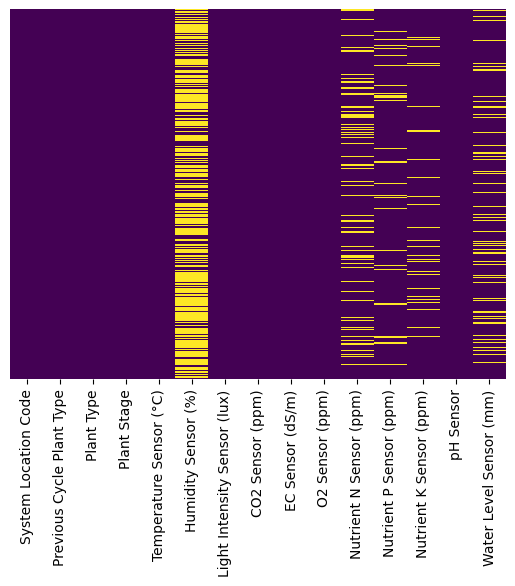

In [16]:
sns.heatmap(df.isnull(), yticklabels=False, cbar=False, cmap='viridis')

We observe that humidity sensor has roughly 68% of missing values, hence we drop it. We will impute for the remaining features

In [17]:
df.drop(columns=['Humidity Sensor (%)'], inplace=True)

In [18]:
df.columns

Index(['System Location Code', 'Previous Cycle Plant Type', 'Plant Type',
       'Plant Stage', 'Temperature Sensor (°C)',
       'Light Intensity Sensor (lux)', 'CO2 Sensor (ppm)', 'EC Sensor (dS/m)',
       'O2 Sensor (ppm)', 'Nutrient N Sensor (ppm)', 'Nutrient P Sensor (ppm)',
       'Nutrient K Sensor (ppm)', 'pH Sensor', 'Water Level Sensor (mm)'],
      dtype='object')

Now, let us check if there are any inconsistencies with our categorical features

In [19]:
df['System Location Code'].unique()

array(['Zone_D', 'Zone_F', 'Zone_G', 'Zone_B', 'Zone_C', 'Zone_A',
       'Zone_E'], dtype=object)

In [20]:
df['Previous Cycle Plant Type'].unique()

array(['Herbs', 'Vine Crops', 'Leafy Greens', 'Fruiting Vegetables'],
      dtype=object)

In [21]:
df['Plant Type'].unique()

array(['Vine Crops', 'herbs', 'fruiting vegetables', 'LEAFY GREENS',
       'FRUITING VEGETABLES', 'Leafy Greens', 'Herbs',
       'Fruiting Vegetables', 'HERBS', 'vine crops', 'leafy greens',
       'VINE CROPS'], dtype=object)

In [22]:
df['Plant Stage'].unique()

array(['Maturity', 'maturity', 'Vegetative', 'seedling', 'MATURITY',
       'Seedling', 'SEEDLING', 'VEGETATIVE', 'vegetative'], dtype=object)

Plant Type and Plant Stage have multiple labels for the same type. We will standardise the labels and have Plant Type match Previous Plant Type

In [23]:
plant_type_mapping = {
    'herbs': 'Herbs',
    'HERBS': 'Herbs',
    'Herbs': 'Herbs',
    'vine crops': 'Vine Crops',
    'VINE CROPS': 'Vine Crops',
    'Vine Crops': 'Vine Crops',
    'leafy greens': 'Leafy Greens',
    'LEAFY GREENS': 'Leafy Greens',
    'Leafy Greens': 'Leafy Greens',
    'fruiting vegetables': 'Fruiting Vegetables',
    'FRUITING VEGETABLES': 'Fruiting Vegetables',
    'Fruiting Vegetables': 'Fruiting Vegetables'
}

plant_stage_mapping = {
    'Maturity': 'Maturity',
    'maturity': 'Maturity',
    'MATURITY': 'Maturity',
    'Vegetative': 'Vegetative',
    'vegetative': 'Vegetative',
    'VEGETATIVE': 'Vegetative',
    'Seedling': 'Seedling',
    'seedling': 'Seedling',
    'SEEDLING': 'Seedling'
}

df['Plant Type'] = df['Plant Type'].replace(plant_type_mapping)
df['Plant Stage'] = df['Plant Stage'].replace(plant_stage_mapping)

In [24]:
print(df['Plant Type'].unique())
print(df['Plant Stage'].unique())

['Vine Crops' 'Herbs' 'Fruiting Vegetables' 'Leafy Greens']
['Maturity' 'Vegetative' 'Seedling']


Before we proceed with the analysis, let us split our data into train and test, so that when we estimate the generalisation error on our test set, it won't be too optimistic. One of our objectives is to categorize the combined Plant Type-Stage so let us check for any imbalances for us to stratify in our split

In [30]:
df['Plant Type-Stage'] = df['Plant Type'] + '-' + df['Plant Stage']

In [33]:
df['Plant Type-Stage'].head()

0               Vine Crops-Maturity
2                    Herbs-Maturity
3    Fruiting Vegetables-Vegetative
4             Leafy Greens-Seedling
5      Fruiting Vegetables-Maturity
Name: Plant Type-Stage, dtype: object

<Axes: xlabel='Plant Type-Stage', ylabel='count'>

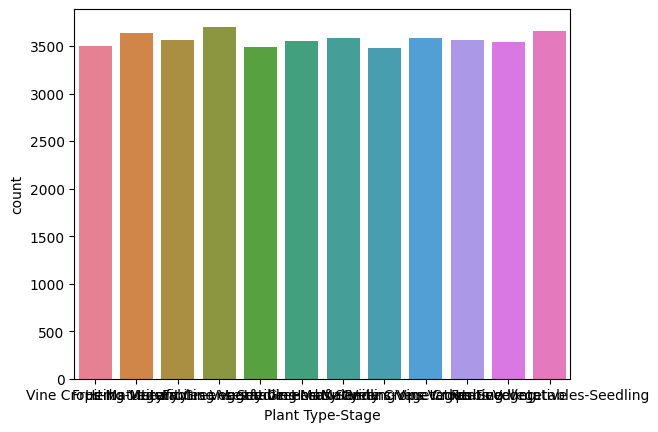

In [ ]:
sns.countplot(data=df, x='Plant Type-Stage', hue='Plant Type-Stage', legend=False)

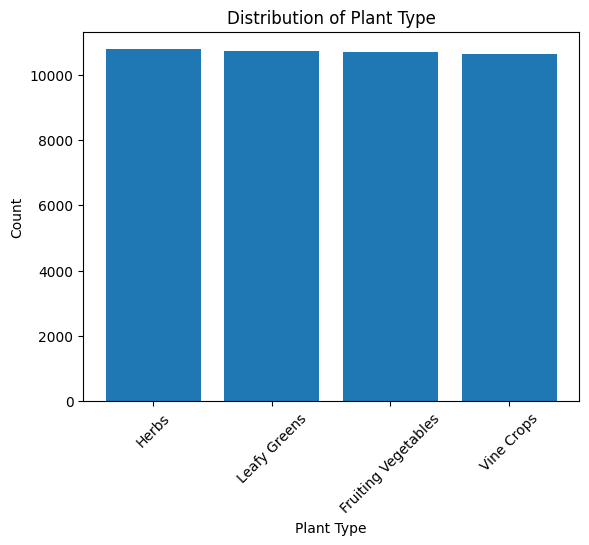

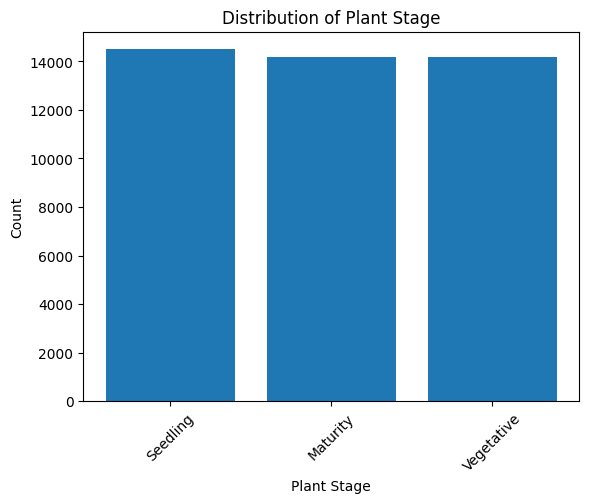

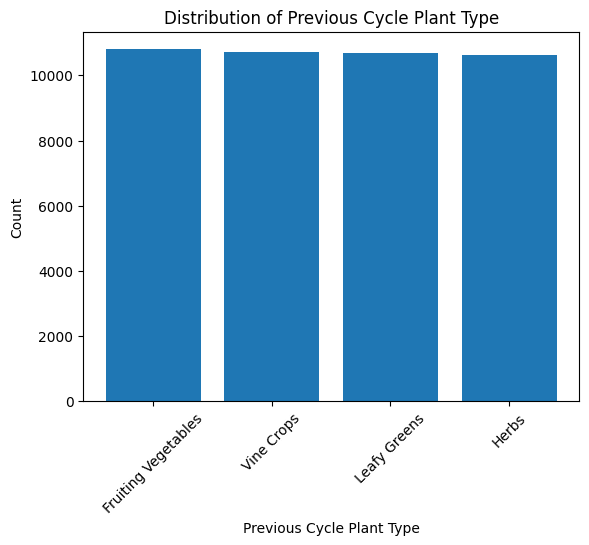

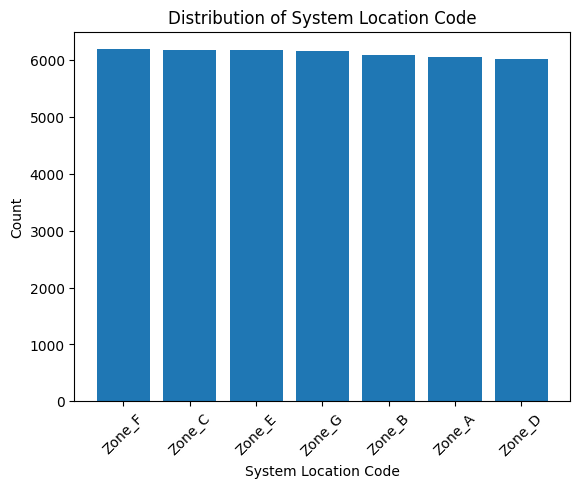

In [35]:
categorical_columns = ['Plant Type', 'Plant Stage', 'Previous Cycle Plant Type', 'System Location Code']

for cat in categorical_columns:
  counts = df[cat].value_counts(dropna=False)
  plt.figure()
  plt.bar(counts.index.astype(str), counts.values)
  plt.title(f'Distribution of {cat}')
  plt.xlabel(cat)
  plt.ylabel('Count')
  plt.xticks(rotation=45)
  plt.show()
  

Our data looks evenly distrubuted. Let us now split our data

In [36]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(df, test_size=0.2, random_state=42)

In [37]:
len(train_set), len(test_set)

(34288, 8572)

In [38]:
df = train_set.copy()

## Univariate Analysis

Let us plot histograms for numerical features again after our initial cleaning and note our observations

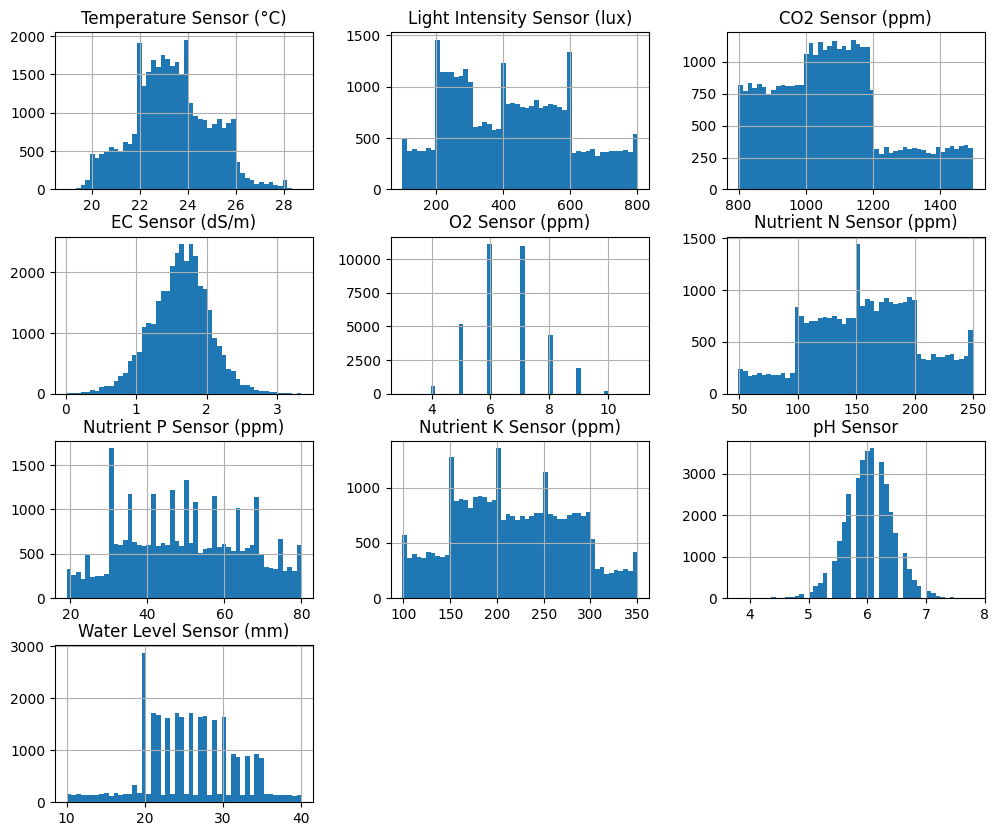

In [42]:
df.hist(bins=50, figsize=(12, 10))
plt.show()

In [43]:
df.describe()

,Temperature Sensor (°C),Light Intensity Sensor (lux),CO2 Sensor (ppm),EC Sensor (dS/m),O2 Sensor (ppm),Nutrient N Sensor (ppm),Nutrient P Sensor (ppm),Nutrient K Sensor (ppm),pH Sensor,Water Level Sensor (mm)
count,34288.000000,34288.000000,34288.000000,34288.000000,34288.000000,28338.000000,30844.000000,32101.000000,34288.000000,29180.000000
mean,23.335361,419.032752,1082.127450,1.624259,6.576995,157.473922,49.876735,217.815208,6.019202,25.700820
std,1.615019,178.575391,172.410784,0.415158,1.142369,45.777789,15.427031,60.850431,0.400908,5.798125
min,18.930000,99.000000,799.000000,0.010000,3.000000,49.000000,19.000000,99.000000,3.800000,10.001955
25%,22.240000,265.000000,949.000000,1.360000,6.000000,124.000000,37.000000,170.000000,5.800000,21.084096
50%,23.260000,410.000000,1070.000000,1.650000,7.000000,158.000000,50.000000,214.000000,6.000000,26.000000
75%,24.390000,556.000000,1177.000000,1.890000,7.000000,190.000000,62.000000,266.000000,6.300000,30.000000
max,28.750000,800.000000,1500.000000,3.350000,11.000000,250.000000,80.000000,350.000000,7.800000,39.998717


In [44]:
df.head()

,System Location Code,Previous Cycle Plant Type,Plant Type,Plant Stage,Temperature Sensor (°C),Light Intensity Sensor (lux),CO2 Sensor (ppm),EC Sensor (dS/m),O2 Sensor (ppm),Nutrient N Sensor (ppm),Nutrient P Sensor (ppm),Nutrient K Sensor (ppm),pH Sensor,Water Level Sensor (mm),Plant Type-Stage
16606,Zone_D,Vine Crops,Herbs,Seedling,26.18,257.0,1041,0.90,6,NaN,37.0,NaN,6.4,26.000000,Herbs-Seedling
43300,Zone_D,Fruiting Vegetables,Leafy Greens,Maturity,21.22,275.0,913,2.15,7,NaN,31.0,284.0,5.7,21.936891,Leafy Greens-Maturity
12864,Zone_C,Fruiting Vegetables,Leafy Greens,Vegetative,21.54,400.0,965,1.84,8,144.0,42.0,247.0,5.9,19.278560,Leafy Greens-Vegetative
2351,Zone_D,Vine Crops,Herbs,Maturity,23.08,385.0,1221,1.72,6,238.0,NaN,290.0,6.2,30.000000,Herbs-Maturity
8671,Zone_B,Herbs,Herbs,Maturity,22.00,475.0,1368,1.30,8,152.0,59.0,327.0,6.4,10.542473,Herbs-Maturity


## Bivariate Analysis

array([[<Axes: xlabel='Temperature Sensor (°C)', ylabel='Temperature Sensor (°C)'>,
        <Axes: xlabel='Light Intensity Sensor (lux)', ylabel='Temperature Sensor (°C)'>,
        <Axes: xlabel='CO2 Sensor (ppm)', ylabel='Temperature Sensor (°C)'>,
        <Axes: xlabel='EC Sensor (dS/m)', ylabel='Temperature Sensor (°C)'>,
        <Axes: xlabel='O2 Sensor (ppm)', ylabel='Temperature Sensor (°C)'>,
        <Axes: xlabel='Nutrient N Sensor (ppm)', ylabel='Temperature Sensor (°C)'>,
        <Axes: xlabel='Nutrient P Sensor (ppm)', ylabel='Temperature Sensor (°C)'>,
        <Axes: xlabel='Nutrient K Sensor (ppm)', ylabel='Temperature Sensor (°C)'>,
        <Axes: xlabel='pH Sensor', ylabel='Temperature Sensor (°C)'>,
        <Axes: xlabel='Water Level Sensor (mm)', ylabel='Temperature Sensor (°C)'>],
       [<Axes: xlabel='Temperature Sensor (°C)', ylabel='Light Intensity Sensor (lux)'>,
        <Axes: xlabel='Light Intensity Sensor (lux)', ylabel='Light Intensity Sensor (lux)'>,
       

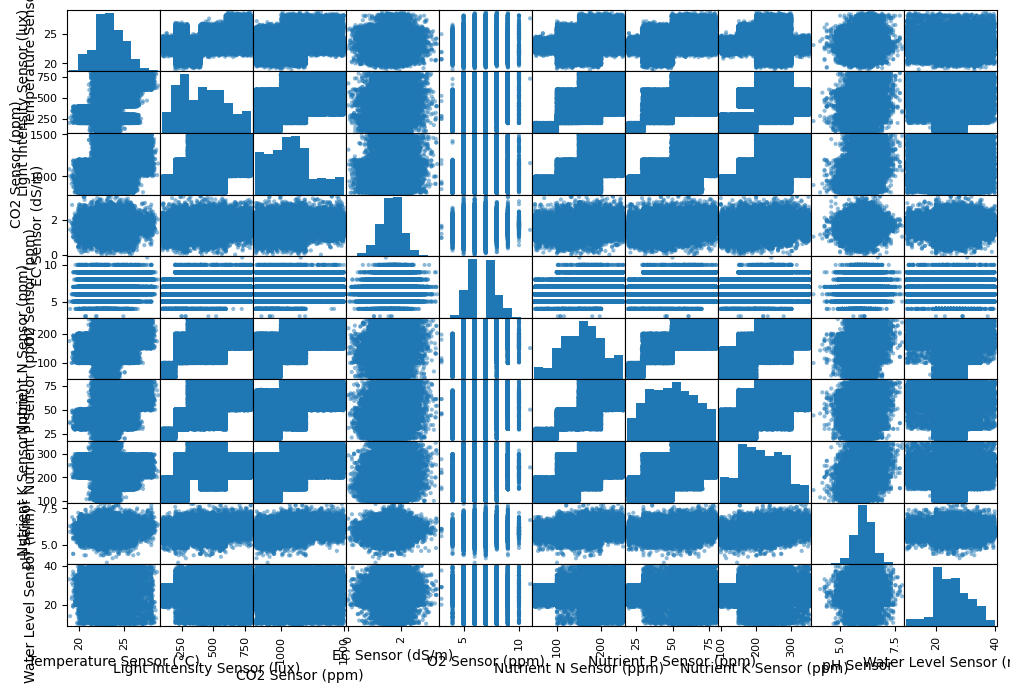

In [52]:
from pandas.plotting import scatter_matrix

attributes = df.select_dtypes(['int64', 'float64']).columns
scatter_matrix(df[attributes], figsize=(12,8))

<Axes: >

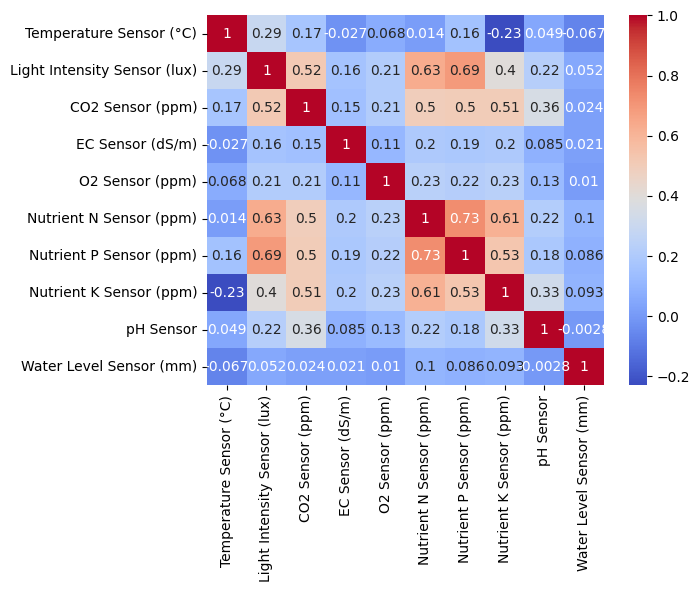

In [53]:
sns.heatmap(df[attributes].corr(), cmap='coolwarm', annot=True)